In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using AdaptiveTransportMap: transform!, evaluate, ncoeff, optimize, negative_log_likelihood!
using DiffResults
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using Polynomials
using Optim: InverseDiagonal
using MLDataUtils
using Test
using ProgressMeter
using Plots

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/aQmWx/src/RecipesBase.jl:116
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [3]:
Ne = 1000
Nx = 2
m = 30

X = sample_banana(Ne);

In [4]:
M = HermiteMap(m, X; diag = true);

In [5]:
optimize(M, X, "kfold"; withconstant = true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


HermiteMap(30, 2, LinearTransform(2, [-0.028091464582764392, 0.9951083886607286], [1.0048807461979798 0.0; 0.0 1.7751408748243158], true), MapComponent[MapComponent(30, 1, 1, IntegratedFunction(30, 1, 1, Rectifier("softplus"), ParametricFunction(ExpandedFunction(30, 1, 1, MultiBasis(Basis of 30 functions: Constant -> 28th degree Probabilistic Hermite function
, 1), [1], [1], [0.006331825640124119]))), 1.0e-6), MapComponent(30, 12, 2, IntegratedFunction(30, 12, 2, Rectifier("softplus"), ParametricFunction(ExpandedFunction(30, 12, 2, MultiBasis(Basis of 30 functions: Constant -> 28th degree Probabilistic Hermite function
, 2), [1 0; 0 1; … ; 0 6; 0 7], [1, 2], [9.54366198907158, -11.365914198733156, 4.9222327457304225, -7.659176928755289, 3.9555816075809465, -4.561945659456991, 0.29132099919024584, -1.633943518800555, 0.29289748738692944, -2.123265865892312, 1.256790972038684, -1.4822007773677672]))), 1.0e-6)])

In [6]:
MpushX = evaluate(M, X)

2×1000 Array{Float64,2}:
 -0.433015    0.364281   0.000963739  …  0.568694   1.22671    0.354727
  0.0744814  -1.29365   -0.0882098       1.04823   -0.904988  -0.93227

In [7]:
S1 = Storage(M.C[1].I.f, X[1:1,:])
S2 = Storage(M.C[2].I.f, X[1:2,:]);

In [8]:
Nlog = 50
logbanana = zeros(Nlog, Nlog)
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)


xrange = range(-4.0; stop = 4.0, length = Nlog)
yrange = range(-4.0; stop = 4.0, length = Nlog)

@showprogress for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y])
        logbanana_approx[i,j] = log_pdf(M, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [9]:
norm(exp.(logbanana)' - exp.(logbanana_approx)')/norm(exp.(logbanana)')

0.07650927175639992

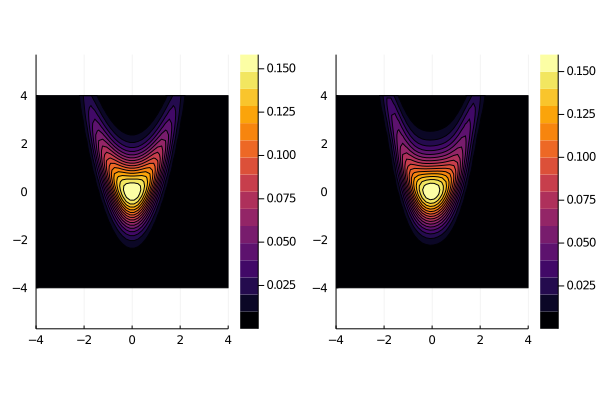

In [10]:
plt = plot(layout = grid(1,2))
contourf!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1, xlim = (xrange[1], xrange[end]))
# scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

contourf!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (xrange[1], xrange[end]))

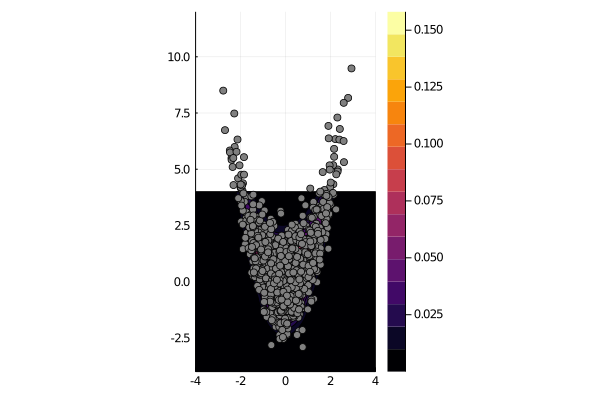

In [75]:
contourf(xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (-Inf, Inf), ylim = (-4, 12))
scatter!(X[1,:], X[2,:]; legend = false, color = :grey, ratio = 1)

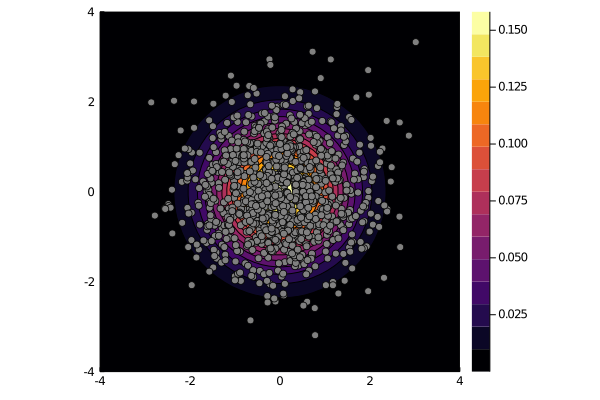

In [76]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [77]:
mean(MpushX; dims = 2)

2×1 Array{Float64,2}:
 0.002484496109979758
 0.0032735154204118553

In [78]:
cov(MpushX; dims = 2)

2×2 Array{Float64,2}:
 0.999992    0.00935871
 0.00935871  1.01407